In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
import pickle
from pathlib import Path
import re
from model_1p7 import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='whitegrid', rc={"font.family": "DejaVu Serif"})

# Debug

In [4]:
df, dff, sim, net = simulate(2, 'V', 0, 13, 80, 'random')

trial 1
trial 10
trial 20
trial 30
trial 40
trial 50
trial 60
trial 70
trial 80


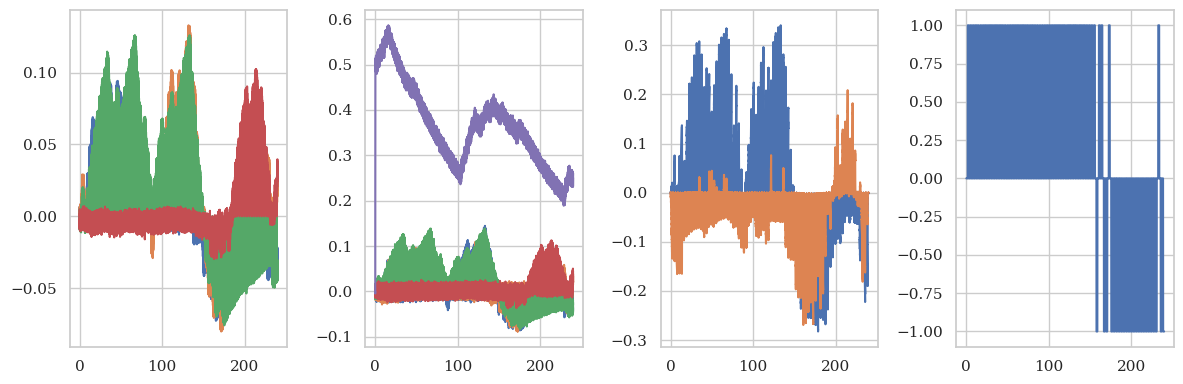

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(12,4))
axes[0].plot(sim.trange(), sim.data[net.p_v][:,:2], label='let')
axes[0].plot(sim.trange(), sim.data[net.p_v][:,2:], label='loc')
axes[1].plot(sim.trange(), sim.data[net.p_vwa][:,:], label='vwa')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa][:,4], label='vwa')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa2][:,0], label='aL')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa2][:,1], label='aR')
# axes[2].plot(sim.trange(), sim.data[net.p_w])
axes[2].plot(sim.trange(), sim.data[net.p_a])
# axes[3].plot(sim.trange(), sim.data[net.p_ch])
axes[3].plot(sim.trange(), sim.data[net.p_dec][:,0], label='dec')
# axes[3].plot(sim.trange(), sim.data[net.p_dec][:,2], label='rt')
# axes[3].plot(sim.trange(), sim.data[net.p_thr])
# axes[3].plot(sim.trange(), sim.data[net.p_rew][:,3], label='acc')
# axes[3].plot(sim.trange(), sim.data[net.p_rew][:,0], label='rew')
# axes[3].plot(sim.trange(), sim.data[net.p_ew])
# axes[3].plot(sim.trange(), sim.data[net.p_mask_learn])
# axes[0].set(xlim=[210,216])
plt.tight_layout()
plt.show()

# Plotting

In [6]:
def adjust_df(df, do_acc=True):
    if do_acc: df['acc'] = df['acc'].replace(-1, 0)
    emp = pd.read_pickle("data/empirical2.pkl")
    block_starts = emp[emp['trial'] == 1].copy()
    
    def classify(row):
        b = row['block']
        if 1 <= b <= 12:
            # Letter blocks: check if it starts with A or B
            start = row['cor_let']
            return f"let_{start}{'B' if start == 'A' else 'A'}"
        elif 13 <= b <= 24:
            # Location blocks: check if starts with left or right
            start_init = 'L' if row['cor_loc'] == 'left' else 'R'
            end_init = 'R' if start_init == 'L' else 'L'
            return f"loc_{start_init}{end_init}"
        return "unknown"

    block_starts['block_label'] = block_starts.apply(classify, axis=1)
    
    # Create a mapping dictionary {block_number: label}
    block_type_map = block_starts.set_index('block')['block_label'].to_dict()
    
    # 4. Apply labels to the main dataframe
    df['block_type'] = df['block'].map(block_type_map)
    
    # block_mapping = emp[['block', 'block_type']].drop_duplicates().set_index('block')['block_type']
    # df['block_type'] = df['block'].map(block_mapping)
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    join_keys = ['monkey', 'session', 'block', 'trial']
    extra_cols = ['rev', 'cor_let', 'cor_loc']
    df = df.merge(emp[join_keys + extra_cols], on=join_keys, how='left')
    return df

In [7]:
def plot_values(nef_data, x='rev'):
    target_blocks = ['loc_RL', 'loc_LR', 'let_AB', 'let_BA']
    pretty_labels = {
        'let_AB': 'What\nA \u2192 B',
        'let_BA': 'What\nB \u2192 A',
        'loc_LR': 'Where\nL \u2192 R',
        'loc_RL': 'Where\nR \u2192 L'
    }
    name_map = {'va': 'A', 'vb': 'B', 'vl': 'L', 'vr': 'R'}
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 7), sharex=True, sharey="col")
    titles = ['Values', r"$\omega$", 'RT']
    columns_to_plot = [['va', 'vb', 'vl', 'vr'], ['w'], ['tdec']]
    for row_idx, b_type in enumerate(target_blocks):
        df = nef_data[nef_data['block_type'] == b_type].copy()
        if df.empty: continue
        for col_idx, cols in enumerate(columns_to_plot):
            ax = axes[row_idx, col_idx]
            plot_df = df.query("rev != 0")
            for metric in cols:
                label_name = name_map.get(metric, metric)
                sns.lineplot(data=plot_df, x=x, y=metric, ax=ax, label=label_name)
            ax.axvline(0, color='black', linestyle='--', alpha=0.3)
            ax.set(xlim=[-45, 45], xticks=[-40, 0, 40], ylabel=None)
            ax.xaxis.grid(False)
            if col_idx == 0:
                ax.set_ylabel(pretty_labels.get(b_type, b_type), rotation=0, labelpad=40, verticalalignment='center')
            if col_idx==0 and row_idx==0:
                ax.legend()
            else:
                if ax.get_legend(): ax.get_legend().remove()
            if row_idx == 0:
                ax.set_title(titles[col_idx], fontweight='bold', pad=20)
            if row_idx == len(target_blocks)-1:
                ax.set(xlabel="Trial (reversal)")
    plt.tight_layout()
    plt.show()
    fig.savefig("plots/values.pdf")

In [8]:
def plot_performance_omega(nef_data, rl_data, label, window_size=7):
    emp = pd.read_pickle("data/empirical2.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    for i, dataset in enumerate([emp, nef_data, rl_data]):
        dataset['super_type'] = dataset['block_type'].map(type_map).fillna(dataset['block_type'])
        dataset['after_rev'] = dataset['rev'] >= 0
        if i<2:
            target_col = 'monkey_accuracy' if 'monkey_accuracy' in dataset.columns else 'acc'
            dataset['smoothed_acc'] = dataset.groupby(['monkey', 'super_type', 'session', 'block', 'after_rev'])[target_col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), sharex=True, sharey='row')
    
    sns.lineplot(data=emp, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[0][0])
    axes[0][0].set_title('Empirical Data')
    axes[0][0].set(xlim=[-45, 45], ylabel='Task Performance', ylim=[0, 1])
    axes[0][0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0][0].legend(title='Block Type')
    axes[0][0].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=nef_data, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[0][1])
    axes[0][1].set_title(f'NEF Model ({label})')
    # axes[0][1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[0][1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0][1].get_legend().remove()
    axes[0][1].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=rl_data, x='rev', y='omega', hue='super_type', hue_order=['what', 'where'], ax=axes[1][0])
    axes[1][0].set(xlabel='Trial Relative to Reversal', ylabel=r"Decoded $\omega$", ylim=[0, 1])
    axes[1][0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1][0].get_legend().remove()
    axes[1][0].xaxis.grid(False)  # Explicitly disable vertical lines

    sns.lineplot(data=nef_data, x='rev', y='w', hue='super_type', hue_order=['what', 'where'], ax=axes[1][1])
    axes[1][1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[1][1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1][1].get_legend().remove()
    axes[1][1].xaxis.grid(False)  # Explicitly disable vertical lines

    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/performance_omega_{label}.pdf")

# Perturbation

In [9]:
control = adjust_df(pd.read_pickle("data/nef/control/nef_data.pkl.xz"))
inh = adjust_df(pd.read_pickle("data/nef/inh/nef_data.pkl.xz"))
pos = adjust_df(pd.read_pickle("data/nef/pos/nef_data.pkl.xz"))
neg = adjust_df(pd.read_pickle("data/nef/neg/nef_data.pkl.xz"))
rl = adjust_df(pd.read_pickle("data/rl_values.pkl"), False)

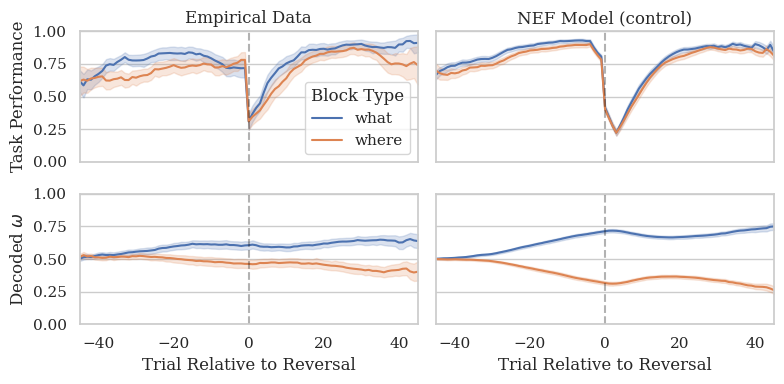

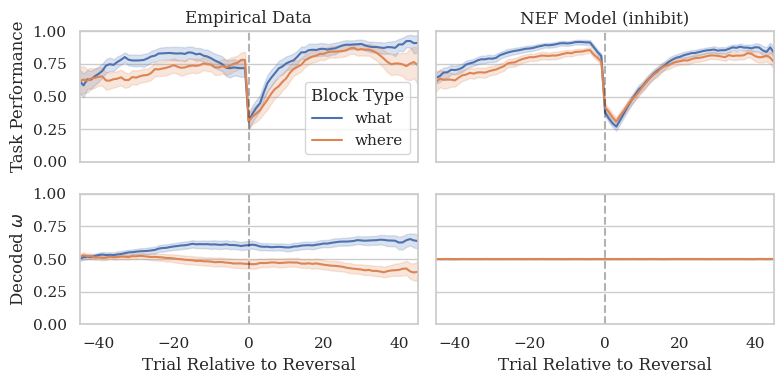

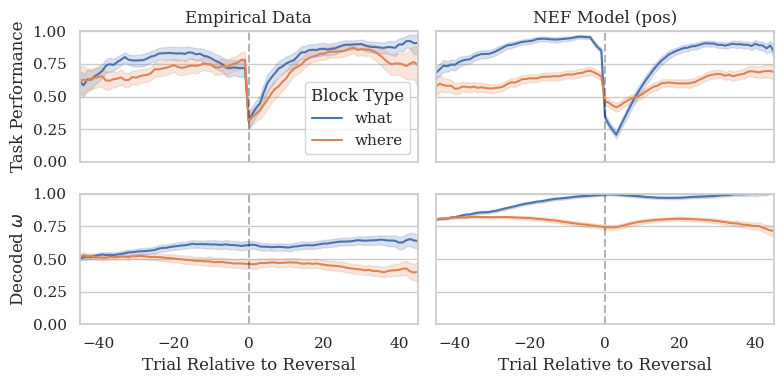

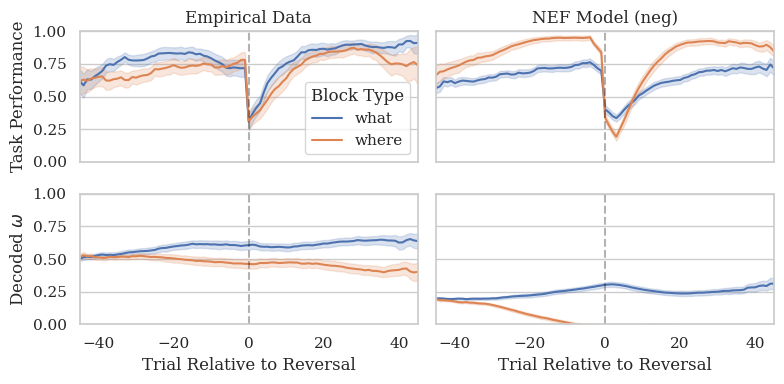

In [6]:
plot_performance_omega(control, rl, 'control')
plot_performance_omega(inh, rl, 'inhibit')
plot_performance_omega(pos, rl, 'pos')
plot_performance_omega(neg, rl, 'neg')

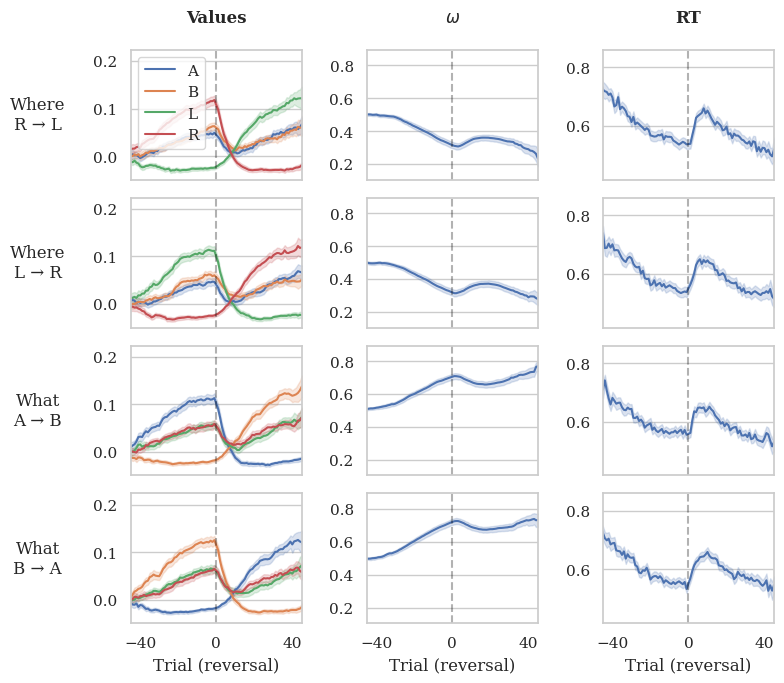

In [10]:
plot_values(control)

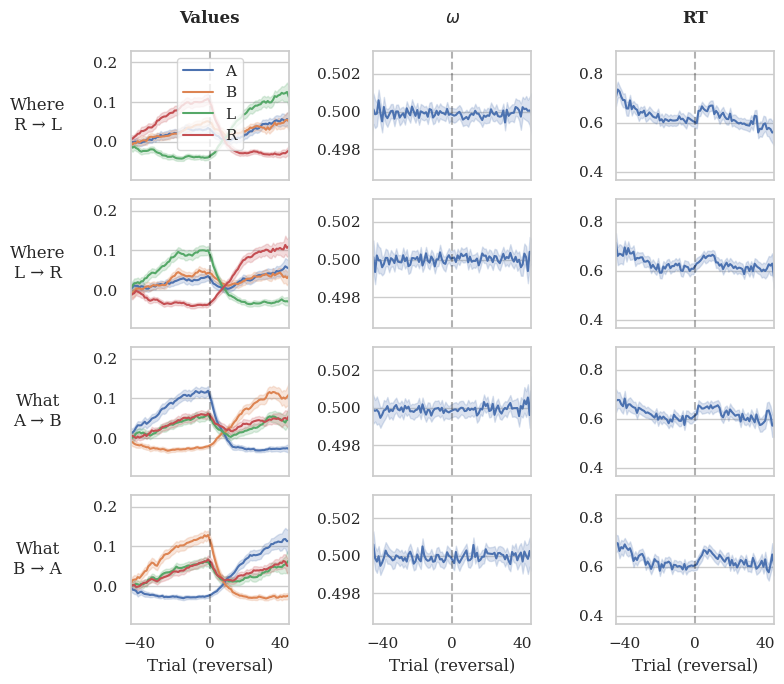

In [19]:
plot_values(inh)

# Ramping

In [8]:
def load_adjust_full(df):
    df['acc'] = df['acc'].replace(-1, 0)
    df['trial'] = (np.floor(df['time'] / 3.0) + 1).astype(int)
    emp = pd.read_pickle("data/empirical2.pkl")
    emp_subset = emp[['monkey', 'session', 'block', 'trial', 'cor_loc', 'cor_let', 'block_type', 'reversal_at_trial']].drop_duplicates()
    join_keys = ['monkey', 'session', 'block', 'trial']
    df = df.merge(emp_subset, on=join_keys, how='left')
    df['rev'] = df['trial'] - df['reversal_at_trial']
    is_left = (df['cor_loc'] == 'left')
    df['acor'] = np.where(is_left, df['al'], df['ar'])
    df['ainc'] = np.where(is_left, df['ar'], df['al'])
    df['t_since_cue'] = df['time'] % 3.0 - 1.0
    df['da'] = df['acor'] - df['ainc']
    for col in ['monkey', 'block_type', 'cor_loc', 'cor_let']:
        df[col] = df[col].astype('category')
    return df

In [15]:
def plot_ramp(df, label, trial_start=38, trial_end=45):
    df = df.query("@trial_start <= rev < @trial_end").copy()
    type_map = {'what': 'What Blocks', 'where': 'Where Blocks'}
    df['super_type'] = df['block_type'].map(type_map)
    categories = ['Where Blocks', 'What Blocks']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True, sharex=True)
    for i, cat in enumerate(categories):
        data_subset = df[df['super_type'] == cat]
        sns.lineplot(data=data_subset, x='t_since_cue', y='da', ax=axes[i], color=palette[0], alpha=1)
        # sns.lineplot(data=data_subset, x='t_since_cue', y='acor', ax=axes[i], color=palette[1], alpha=0.3, label='a correct')
        # sns.lineplot(data=data_subset, x='t_since_cue', y='ainc', ax=axes[i], color=palette[2], alpha=0.3, label='a incorrect')
        # sns.lineplot(data=data_subset, x='t_since_cue', y='thr', ax=axes[i], color=palette[3], alpha=0.3, label='a thr')
        axes[i].set_title(cat+f" ({label})", fontweight='bold', fontsize=14)
        axes[i].set(xlabel='Time from Cue (s)', ylabel="Action Value\n(v correct - v incorrect)" if i == 0 else None)
        axes[i].axvline(0, color='black', linestyle='--', alpha=0.3)
        axes[i].set_xticks(np.linspace(-1,1,5))
        axes[i].set_xlim([-1, 1])
    # axes[0].set(ylim=[0,0.7])
    # axes[1].set(ylim=[0,0.2], yticks=[0.0, 0.05, 0.1, 0.15, 0.2])
    # axes[0].legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/ramp_{label}.pdf")

In [16]:
control_full = load_adjust_full(pd.read_pickle("data/nef/control/nef_data_full.pkl.xz"))
inh_full = load_adjust_full(pd.read_pickle("data/nef/inh/nef_data_full.pkl.xz"))
pos_full = load_adjust_full(pd.read_pickle("data/nef/pos/nef_data_full.pkl.xz"))
neg_full = load_adjust_full(pd.read_pickle("data/nef/neg/nef_data_full.pkl.xz"))

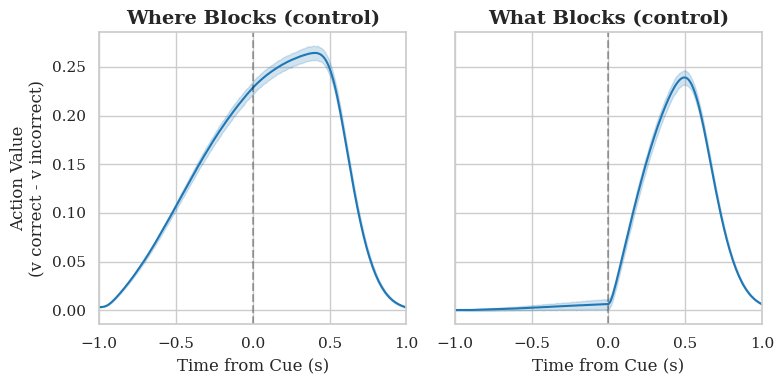

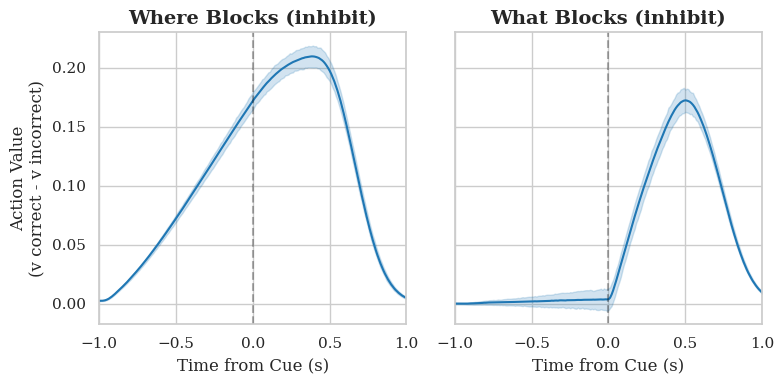

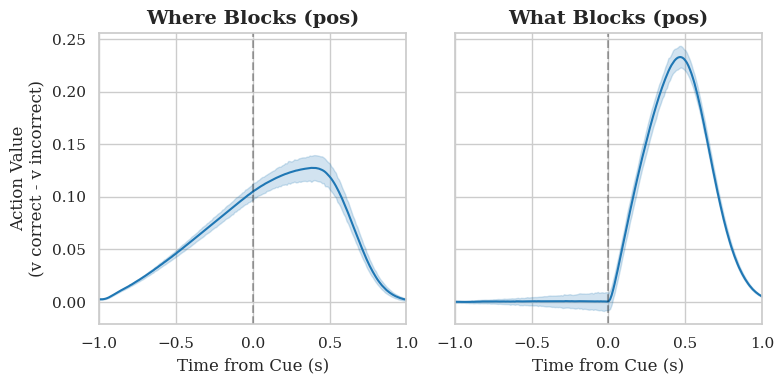

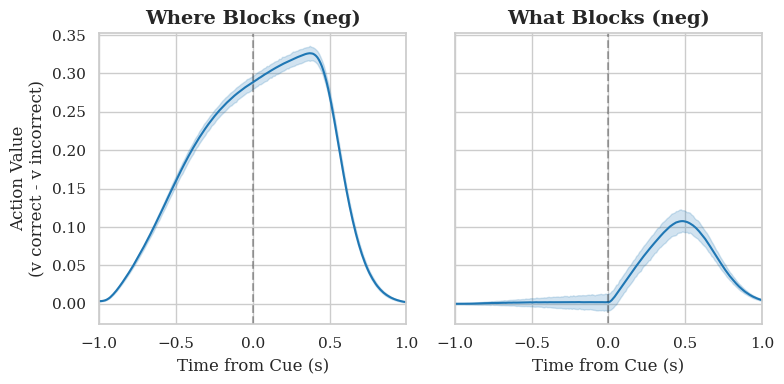

In [17]:
plot_ramp(control_full, "control")
plot_ramp(inh_full, "inhibit")
plot_ramp(pos_full, "pos")
plot_ramp(neg_full, "neg")